In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading and preprocessing data...
Original Cardio Data Count: 70000
Original Heart Data Count: 1025
Original Cardio Data:
   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  

Original Heart Data:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155   

<Figure size 640x480 with 0 Axes>

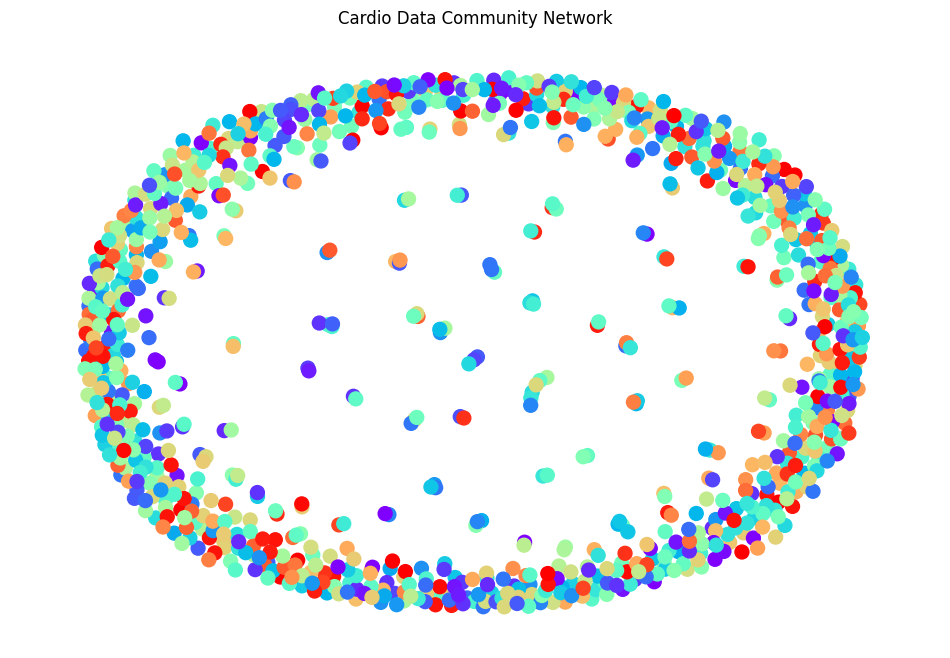

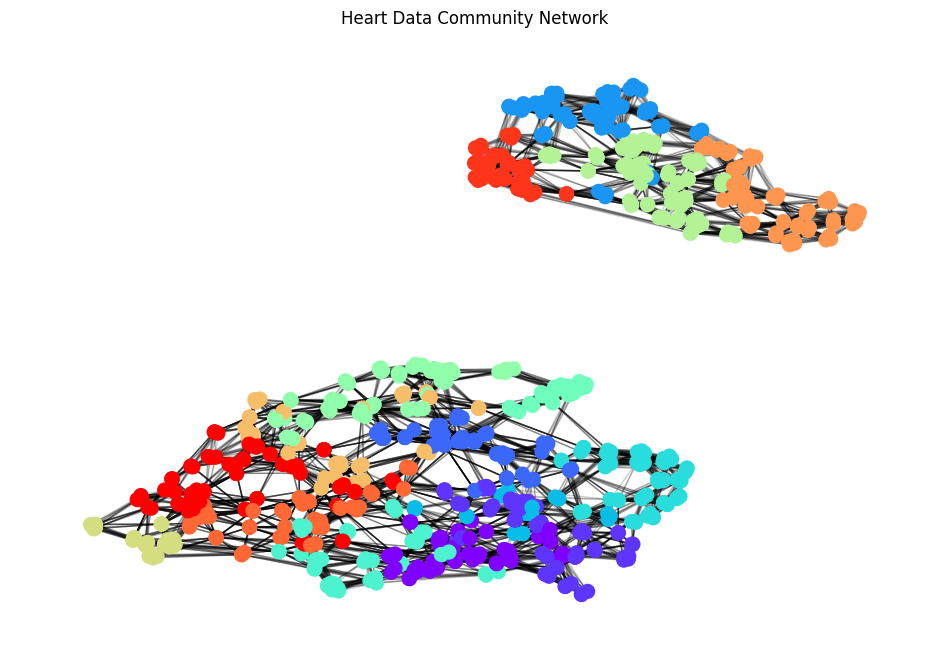

In [10]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import normalized_mutual_info_score, f1_score
from sklearn.metrics.cluster import contingency_matrix
from scipy.sparse import csr_matrix

def load_and_preprocess():
    # Load datasets
    cardio_df = pd.read_csv('/content/drive/MyDrive/AJS/cardio_train.csv', sep=';')
    heart_df = pd.read_csv('/content/drive/MyDrive/AJS/heart.csv')

    # Display original data counts
    print("Original Cardio Data Count:", len(cardio_df))
    print("Original Heart Data Count:", len(heart_df))

    # Display original data
    print("Original Cardio Data:")
    print(cardio_df.head())
    print("\nOriginal Heart Data:")
    print(heart_df.head())

    # Fix gender values in cardio data
    cardio_df['gender'] = cardio_df['gender'].replace({1: 0, 2: 1})

    # Remove outliers using IQR method
    def remove_outliers(df, features):
        for feature in features:
            Q1 = df[feature].quantile(0.25)
            Q3 = df[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
        return df

    # Normalize age values in cardio data to years, accounting for leap years
    cardio_df['age'] = cardio_df['age'] / 365.25  # Convert days to years

    # Calculate BMI
    cardio_df['BMI'] = cardio_df['weight'] / ((cardio_df['height'] / 100) ** 2)

    cardio_features_for_outliers = ['age', 'BMI', 'ap_hi', 'ap_lo']
    heart_features_for_outliers = ['age', 'trestbps', 'chol', 'thalach']

    cardio_df = remove_outliers(cardio_df, cardio_features_for_outliers)
    heart_df = remove_outliers(heart_df, heart_features_for_outliers)

    # Drop height and weight columns
    cardio_df.drop(columns=['height', 'weight'], inplace=True)

    # Display data counts after cleaning
    print("\nCardio Data Count After Cleaning:", len(cardio_df))
    print("Heart Data Count After Cleaning:", len(heart_df))

    # Display data after cleaning
    print("\nCardio Data After Cleaning:")
    print(cardio_df.head())
    print("\nHeart Data After Cleaning:")
    print(heart_df.head())

    # Select relevant features for network creation
    cardio_features = ['age', 'gender', 'BMI', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']
    heart_features = ['age', 'sex', 'trestbps', 'chol', 'thalach']

    # Standardize the features
    scaler = StandardScaler()
    cardio_scaled = scaler.fit_transform(cardio_df[cardio_features])
    heart_scaled = scaler.fit_transform(heart_df[heart_features])

    # Display feature statistics after cleaning
    print("\nFeature Statistics After Cleaning (Cardio):")
    print(cardio_df[cardio_features].describe())
    print("\nFeature Statistics After Cleaning (Heart):")
    print(heart_df[heart_features].describe())

    return cardio_scaled, heart_scaled, cardio_df, heart_df

def create_similarity_network(data, n_neighbors=10):
    """
    Create network using k-nearest neighbors for memory efficiency
    """
    # Create sparse similarity matrix using k-nearest neighbors
    A_knn = kneighbors_graph(data, n_neighbors=n_neighbors, mode='distance', include_self=False)

    # Convert distances to similarities
    A_knn.data = np.exp(-A_knn.data)

    # Make the matrix symmetric
    A_symmetric = 0.5 * (A_knn + A_knn.T)

    # Create networkx graph from sparse matrix
    G = nx.from_scipy_sparse_array(A_symmetric)

    return G

def detect_communities(G):
    try:
        import community.community_louvain as community
    except ImportError:
        print("Please install python-louvain package: pip install python-louvain")
        return None

    communities = community.best_partition(G)
    return communities

def visualize_network(G, communities, max_nodes=1000):
    """
    Visualize network with option to sample for large networks
    """
    if len(G) > max_nodes:
        # Sample nodes for visualization
        nodes = list(G.nodes())
        sampled_nodes = np.random.choice(nodes, max_nodes, replace=False)
        G_sample = G.subgraph(sampled_nodes)
        communities_sample = {node: communities[node] for node in sampled_nodes}
    else:
        G_sample = G
        communities_sample = communities

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G_sample)
    nx.draw_networkx_nodes(G_sample, pos,
                          node_color=list(communities_sample.values()),
                          cmap=plt.cm.rainbow,
                          node_size=100)
    nx.draw_networkx_edges(G_sample, pos, alpha=0.2)
    plt.title(f"Healthcare Data Community Network (showing {len(G_sample)} nodes)")
    plt.axis('off')
    return plt

def calculate_purity(true_labels, predicted_labels):
    contingency = contingency_matrix(true_labels, predicted_labels)
    return np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)

def calculate_nmi(true_labels, predicted_labels):
    return normalized_mutual_info_score(true_labels, predicted_labels)

def calculate_f_measure(true_labels, predicted_labels):
    unique_true = np.unique(true_labels)
    f1_scores = []

    for label in unique_true:
        true_binary = (true_labels == label).astype(int)
        pred_binary = (predicted_labels == label).astype(int)
        f1_scores.append(f1_score(true_binary, pred_binary))

    return np.mean(f1_scores)

def evaluate_communities(communities, true_labels):
    predicted_labels = list(communities.values())

    metrics = {
        'purity': calculate_purity(true_labels, predicted_labels),
        'nmi': calculate_nmi(true_labels, predicted_labels),
        'f_measure': calculate_f_measure(true_labels, predicted_labels)
    }

    return metrics

def analyze_communities(G, communities, df, features):
    n_communities = len(set(communities.values()))

    community_stats = {}
    for community_id in range(n_communities):
        nodes = [node for node in communities.keys()
                if communities[node] == community_id]

        subgraph = G.subgraph(nodes)
        sub_df = df.iloc[nodes]

        community_stats[community_id] = {
            'size': len(nodes),
            'density': nx.density(subgraph),
            'avg_degree': sum(dict(G.degree(nodes)).values()) / len(nodes)
        }

        for feature in features:
            community_stats[community_id][f'avg_{feature}'] = sub_df[feature].mean()

    return community_stats

def main():
    # Load and preprocess data
    print("Loading and preprocessing data...")
    cardio_scaled, heart_scaled, cardio_df, heart_df = load_and_preprocess()

    # Create networks
    print("Creating networks...")
    cardio_network = create_similarity_network(cardio_scaled, n_neighbors=20)
    heart_network = create_similarity_network(heart_scaled, n_neighbors=20)

    # Detect communities
    print("Detecting communities...")
    cardio_communities = detect_communities(cardio_network)
    heart_communities = detect_communities(heart_network)

    # Evaluate communities
    print("Evaluating communities...")
    cardio_metrics = evaluate_communities(cardio_communities, cardio_df['cardio'])
    heart_metrics = evaluate_communities(heart_communities, heart_df['target'])

    # Visualize networks
    print("Visualizing networks...")
    plt.figure(1)
    visualize_network(cardio_network, cardio_communities)
    plt.title("Cardio Data Community Network")

    plt.figure(2)
    visualize_network(heart_network, heart_communities)
    plt.title("Heart Data Community Network")

    # Analyze communities
    print("Analyzing communities...")
    cardio_features = ['age', 'gender', 'BMI', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']
    heart_features = ['age', 'sex', 'trestbps', 'chol', 'thalach']
    cardio_stats = analyze_communities(cardio_network, cardio_communities, cardio_df, cardio_features)
    heart_stats = analyze_communities(heart_network, heart_communities, heart_df, heart_features)

    # Display network statistics
    print("\nNetwork Statistics (Cardio):")
    print(f"Number of nodes: {cardio_network.number_of_nodes()}")
    print(f"Number of edges: {cardio_network.number_of_edges()}")
    print(f"Density: {nx.density(cardio_network)}")

    print("\nNetwork Statistics (Heart):")
    print(f"Number of nodes: {heart_network.number_of_nodes()}")
    print(f"Number of edges: {heart_network.number_of_edges()}")
    print(f"Density: {nx.density(heart_network)}")

    return cardio_stats, heart_stats, cardio_metrics, heart_metrics

if __name__ == "__main__":
    cardio_stats, heart_stats, cardio_metrics, heart_metrics = main()

    print("\nCardio Community Statistics:")
    print(pd.DataFrame(cardio_stats).T)
    print("\nCardio Evaluation Metrics:")
    print(pd.DataFrame([cardio_metrics]))

    print("\nHeart Community Statistics:")
    print(pd.DataFrame(heart_stats).T)
    print("\nHeart Evaluation Metrics:")
    print(pd.DataFrame([heart_metrics]))